In [1]:
!pip install numpy Pillow Matplotlib pandas seaborn scikit-learn requests scikit-image mlxtend prefixspan scikit-fuzzy umap-learn openpyxl stanza torch torchvision tesseract pytesseract nltk wordcloud spacy tensorflow==2.19.0 tensorflow-datasets opencv-python ucimlrepo nbconvert

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 40.9 MB/s eta 0:00:00
  Created wheel for prefixspan: filename=prefixspan-0.5.2-py3-none-any.whl size=11215 sha256=251cfad8ace5b6feb6bc7ad32cd61bf795c5a0345ad262d503965ade6b23d1b3
  Stored in directory: /root/.cache/pip/wheels/72/36/65/f9e2bbe4998ab4cdf6e7a015f38bdbb6925301dcf2cce34a88
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562552 sha256=a505c6b25d15fe665e01470e2dd53a67ea6a596bd66686ec326148935343a438
  Stored in directory: /root/.cache/pip/wheels/13/1f/8e/2d6c0e358fd6d01ca80ecd9185a374bcda358

In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import IPython.display as display

In [3]:
dataset_name = "facades"

In [4]:
path_to_zip = tf.keras.utils.get_file(
    f"{dataset_name}.tar.gz",
    f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz",
    extract=True
)
path_to_zip = pathlib.Path(path_to_zip)
extraction_dir = f'{dataset_name}_extracted/{dataset_name}'

PATH = path_to_zip.parent/extraction_dir

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [5]:
sample_image = tf.io.read_file(str(PATH/'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


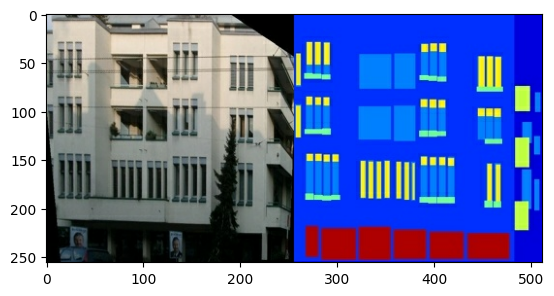

In [6]:
plt.imshow(sample_image)

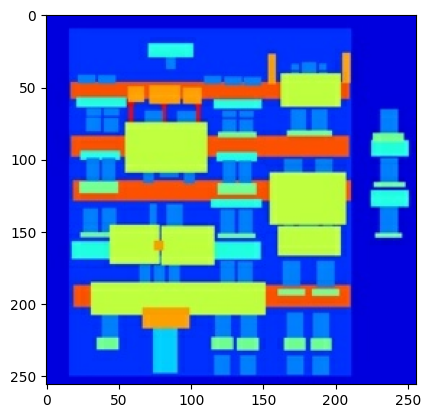

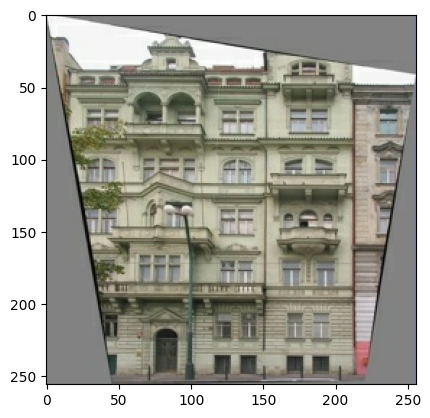

In [7]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

inp,re = load(str(PATH / 'train/100.jpg'))
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [8]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [11]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)
  input_image, real_image = random_crop(input_image, real_image)
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

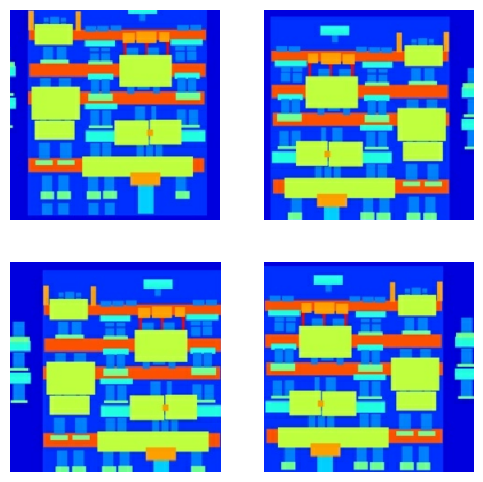

In [13]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [14]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
def load_image_tests(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

Con esto generamos nuestro dataset de entrenamiento/testeo

In [16]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
  test_dataset = test_dataset.map(load_image_tests)

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.0, 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [21]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.0, 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

In [22]:
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [23]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4)
  ]
  initializer = tf.random_normal_initializer(0.0, 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                     activation='tanh')
  x = inputs
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

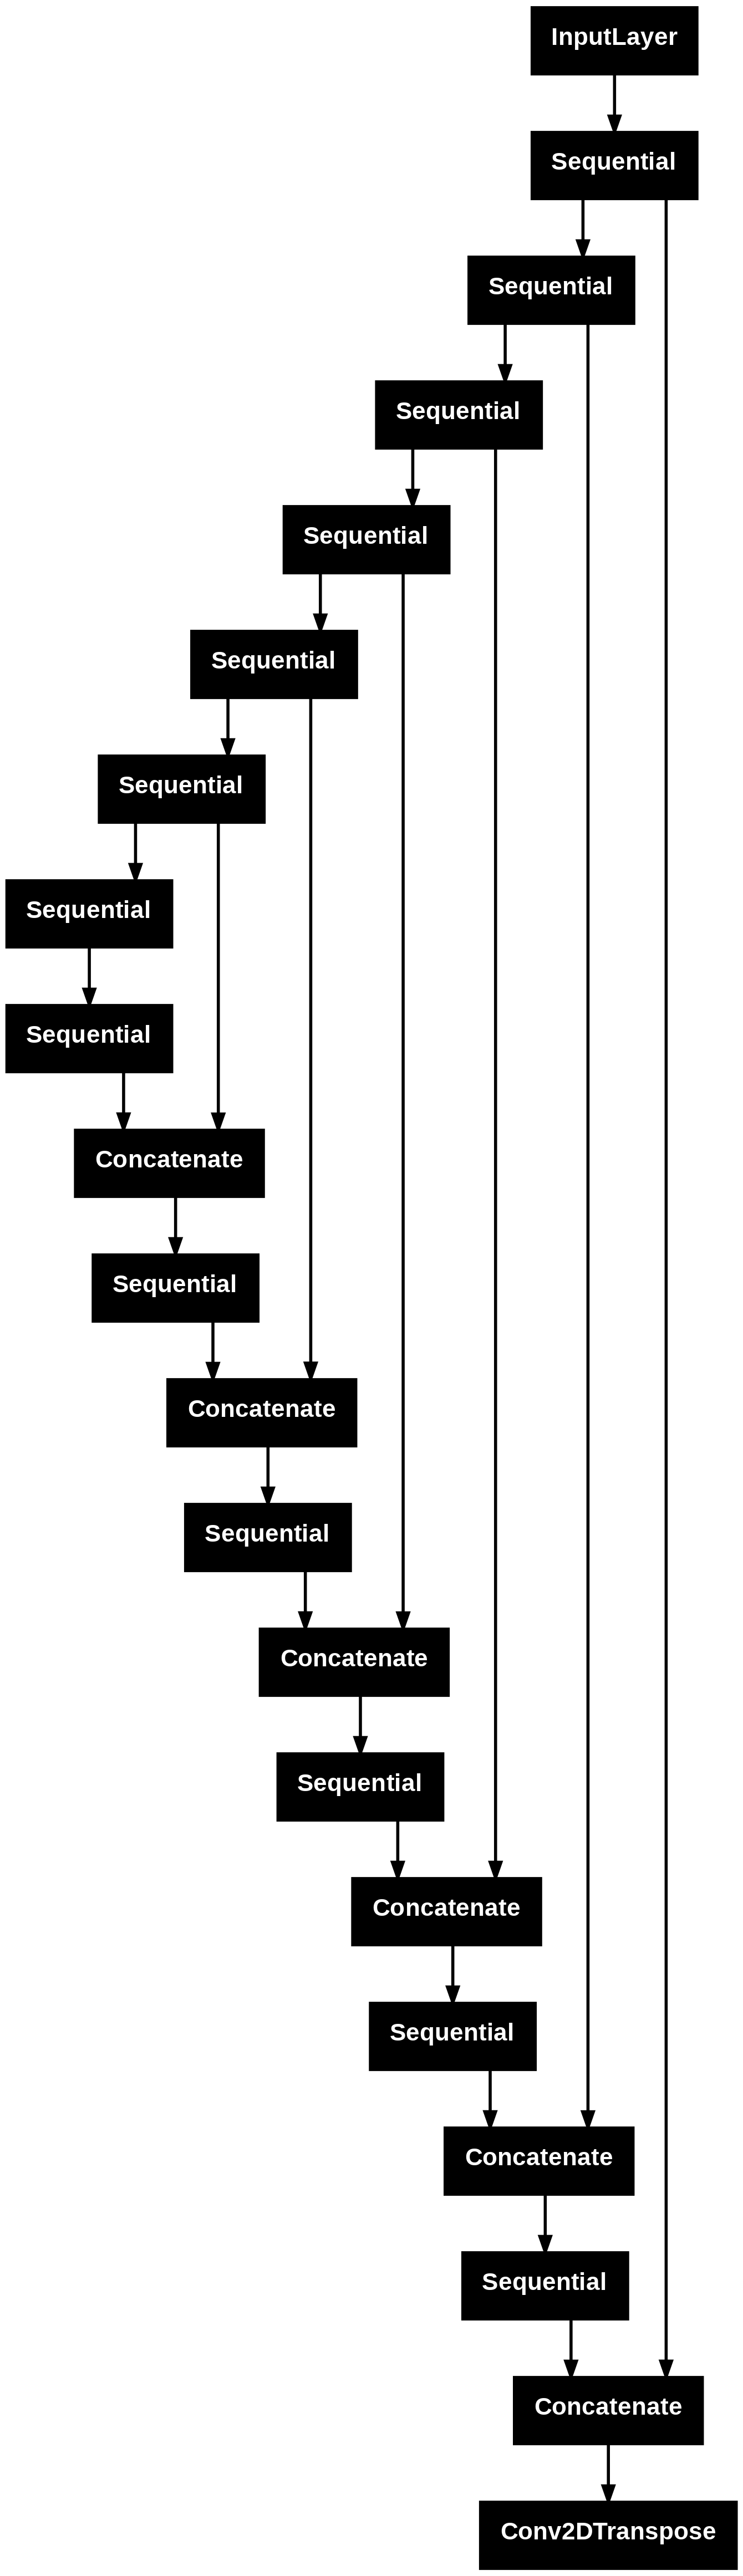

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator)

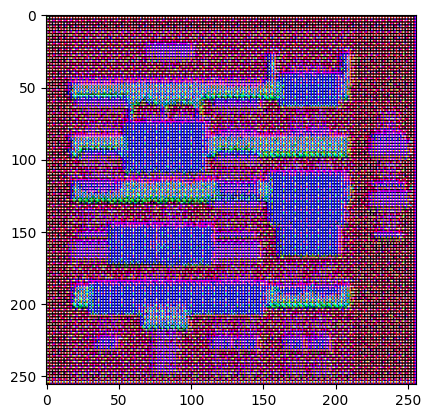

In [25]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])